# Fast Gaussian Process Regression

## Setup

In [52]:
import qmcpy as qp 
import torch 
import numpy as np 
import scipy.stats
import pandas as pd
from matplotlib import pyplot,cm,colors

In [53]:
#pyplot.style.use("seaborn-whitegrid")
LW = 3
CISIZE = .95
ZSTAR = scipy.stats.norm.ppf(CISIZE+(1-CISIZE)/2)
MARKERSIZE = 50
CMAP = cm.inferno
ALPHA = .5
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("./xkcd_colors.txt",comment="#").iloc[:,0].tolist()][::-1]

In [54]:
torch.set_default_dtype(torch.float64)
DEVICE = "cpu"

## Test functions

In [127]:
def f_grad_f(f,x):
    assert x.ndim==2
    d = x.shape[1]
    xs = [x[:,j] for j in range(d)]
    for j in range(d): xs[j].requires_grad_()
    x = torch.vstack(xs).T
    y = f(x)
    grad = [None]*d 
    for j in range(d):
        grad[j] = torch.autograd.grad(y,xs[j],grad_outputs=torch.ones_like(y),create_graph=True)[0]
    y_grad_y = torch.vstack([y]+grad).T 
    return y_grad_y.detach()
def f_curve_1d(x):
    return np.pi*x[:,0]*torch.sin(4*np.pi*x[:,0])*torch.exp(-.01/(1/2-torch.abs(x[:,0]-1/2)))
def f_G(x): # GFunction from https://www.sfu.ca/~ssurjano/gfunc.html
    assert x.ndim==2
    d = x.shape[1] 
    a = (torch.arange(1,d+1,device=DEVICE)-2)/2
    y = torch.prod((torch.abs(4*x-2)+a)/(1+a),dim=1)
    return y
def f_peaks(x): # peaks function 
    x = 6*x-3
    x1,x2 = x[:,0],x[:,1]
    t1 = 3*(1-x1)**2*torch.exp(-x1**2-(x2+1)**2)
    t2 = 10*(x1/5-x1**3-x2**5)*torch.exp(-x1**2-x2**2)
    t3 = 1/3*torch.exp(-(x1-1)**2-x2**2)
    return t1-t2-t3
def f_ackley(x, a=20, b=0.2, c=2*np.pi, scaling=32.768): # https://www.sfu.ca/~ssurjano/ackley.html
    x = 2*scaling*x-scaling
    t1 = a*torch.exp(-b*torch.sqrt(torch.mean(x**2,1)))
    t2 = torch.exp(torch.mean(torch.cos(c*x),1))
    t3 = a+np.exp(1)
    y = -t1-t2+t3
    return y
def f_brownian_motion(t, seed=23, numklterms=250): # eq 6.8 https://artowen.su.domains/mc/Ch-processes.pdf
    assert t.size(1)==1
    j = torch.arange(numklterms,device=DEVICE)
    z_j = torch.from_numpy(np.random.Generator(np.random.PCG64(seed)).uniform(0,1,numklterms)).to(DEVICE)
    bm = np.sqrt(2)/np.pi*(z_j*2/(2*j+1)*torch.sin((2*j+1)/2*np.pi*t)).sum(1)
    return bm
def f_branin_2d(x, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)): # https://www.sfu.ca/~ssurjano/branin.html
    assert x.size(1)==2
    x1,x2 = 15*x[:,0]-5,15*x[:,1]
    y = a*(x2-b*x1**2+c*x1-r)**2+s*(1-t)*torch.cos(x1)+s
    return y
def f_camel_six_hump_2d(x): # https://www.indusmic.com/post/six-hump-camel-function
    assert x.size(1)==2
    x1,x2 = 6*x[:,0]-3,4*x[:,1]-2
    y = (4-2.1*x1**2+x1**4/3)*x1**2+x1*x2+(-4+4*x2**2)*x2**2
    return y 
def styblinski_tang(x): # https://www.sfu.ca/~ssurjano/stybtang.html
    x = 10*x-5
    y = 1/2*torch.sum(x**4-16*x**2+5*x,1)
    return y
def hartmann_6d(x):
    assert x.size(1)==6 
    alpha = torch.tensor([1.0, 1.2, 3.0, 3.2])
    A = torch.tensor([
        [10,   3,   17,   3.5, 1.7, 8],
        [0.05, 10,  17,   0.1, 8,   14],
        [3,    3.5, 1.7,  10,  17,  8],
        [17,   8,   0.05, 10,  0.1,  14]])
    P = 10**(-4)*torch.tensor([
        [1312, 1696, 5569, 124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091, 381]])
    y = -1/1.94*(2.58+torch.sum(alpha*torch.exp(-torch.einsum("ij,rij->ri",A,(x[:,None,:]-P)**2)),1))
    return y
def welch(x):
    assert x.size(1)==20
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20 = x[:,0],x[:,1],x[:,2],x[:,3],x[:,4],x[:,5],x[:,6],x[:,7],x[:,8],x[:,9],x[:,10],x[:,11],x[:,12],x[:,13],x[:,14],x[:,15],x[:,16],x[:,17],x[:,18],x[:,19]
    y = 5*x12/(1+x1)+5*(x4-x20)**2+x5+40*x19**3-5*x19+0.05*x2+0.08*x3-0.03*x6+0.03*x7-0.09*x9-0.01*x10-0.07*x11+0.25*x13**2-0.04*x14+0.06*x15-0.01*x17-0.03*x18
    return y

## Grid vs lattice vs digital net

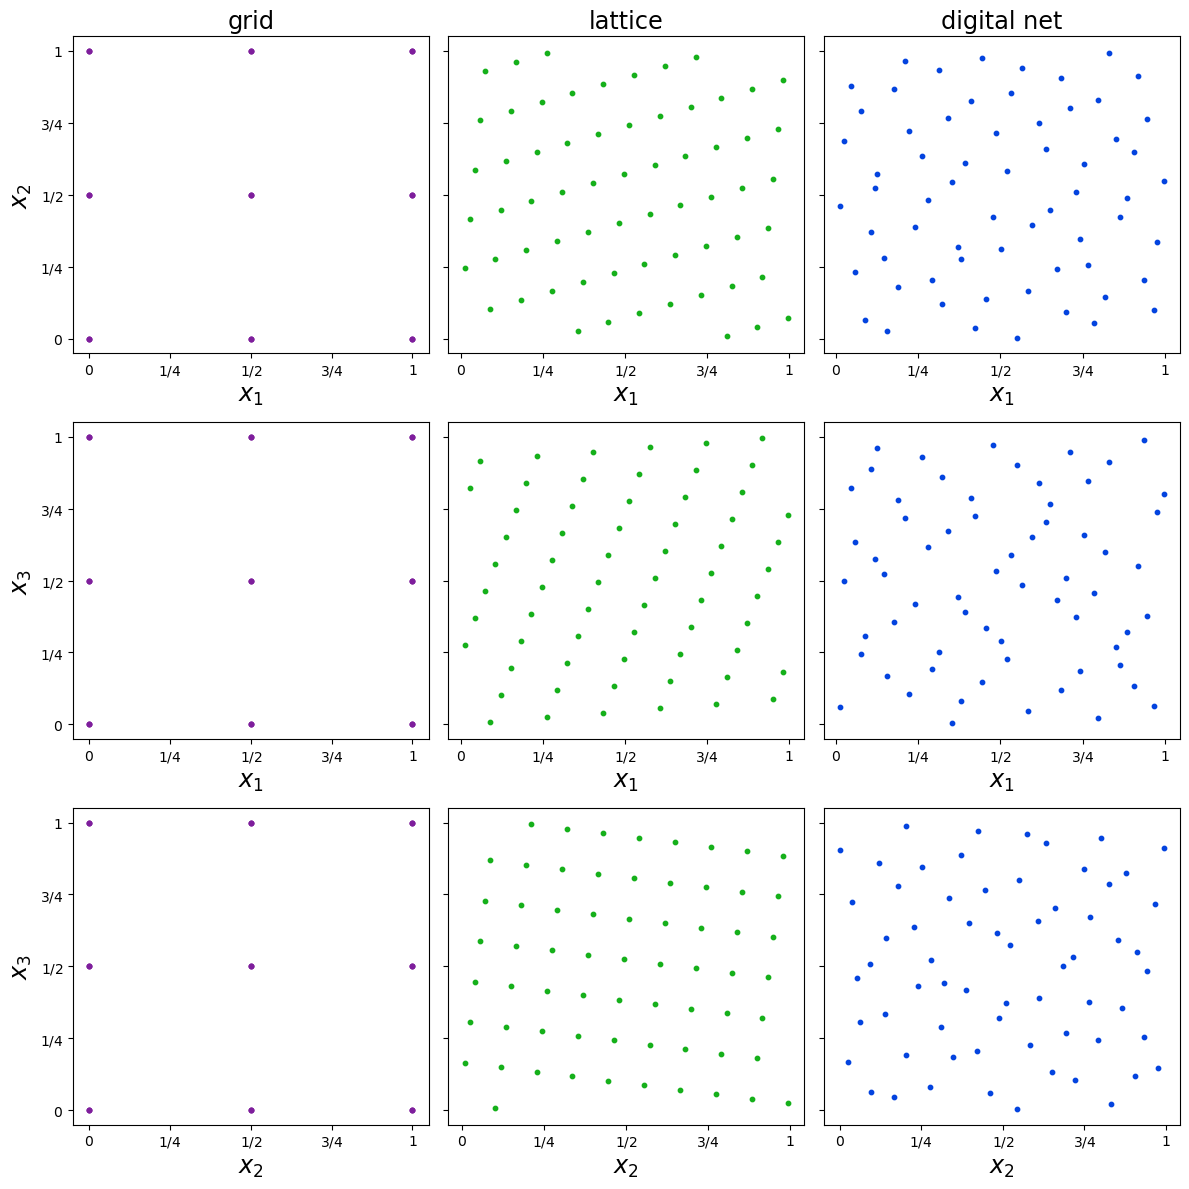

In [56]:
n = 2**6
d = 3
ngrid = n**(1/d)
assert np.allclose(ngrid%1,0) or np.allclose(ngrid%1,1)
gridmesh = torch.meshgrid(*(torch.linspace(0,1,int(ngrid)) for j in range(d)),indexing="ij")
grid = torch.vstack([gridmesh[j].flatten() for j in range(d)]).T 
x_lattice = qp.Lattice(d,seed=7)(n)
x_dnb2 = qp.DigitalNetB2(d,seed=7)(n)
fig,ax = pyplot.subplots(nrows=3,ncols=3,figsize=(4*3,4*3),sharey="row")
S = 10
for j,(name,x) in enumerate(zip(["grid","lattice","digital net"],[grid,x_lattice,x_dnb2])):
    ax[0,j].set_title(name,fontsize="xx-large")
    ax[0,j].scatter(x[:,0],x[:,1],s=S,color=COLORS[j])
    ax[1,j].scatter(x[:,0],x[:,2],s=S,color=COLORS[j])
    ax[2,j].scatter(x[:,1],x[:,2],s=S,color=COLORS[j])
    ax[0,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[1,j].set_xlabel(r"$x_1$",fontsize="xx-large")
    ax[2,j].set_xlabel(r"$x_2$",fontsize="xx-large")
    for i in range(3):
        ax[i,j].set_xticks([0,1/4,1/2,3/4,1])
        ax[i,j].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
        ax[i,j].set_yticks([0,1/4,1/2,3/4,1])
        ax[i,j].set_yticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
ax[0,0].set_ylabel(r"$x_2$",fontsize="xx-large")
ax[1,0].set_ylabel(r"$x_3$",fontsize="xx-large")
ax[2,0].set_ylabel(r"$x_3$",fontsize="xx-large")
fig.tight_layout()
fig.savefig("./fgpr_figs/points.pdf",dpi=256,bbox_inches="tight")

## Prior Draws

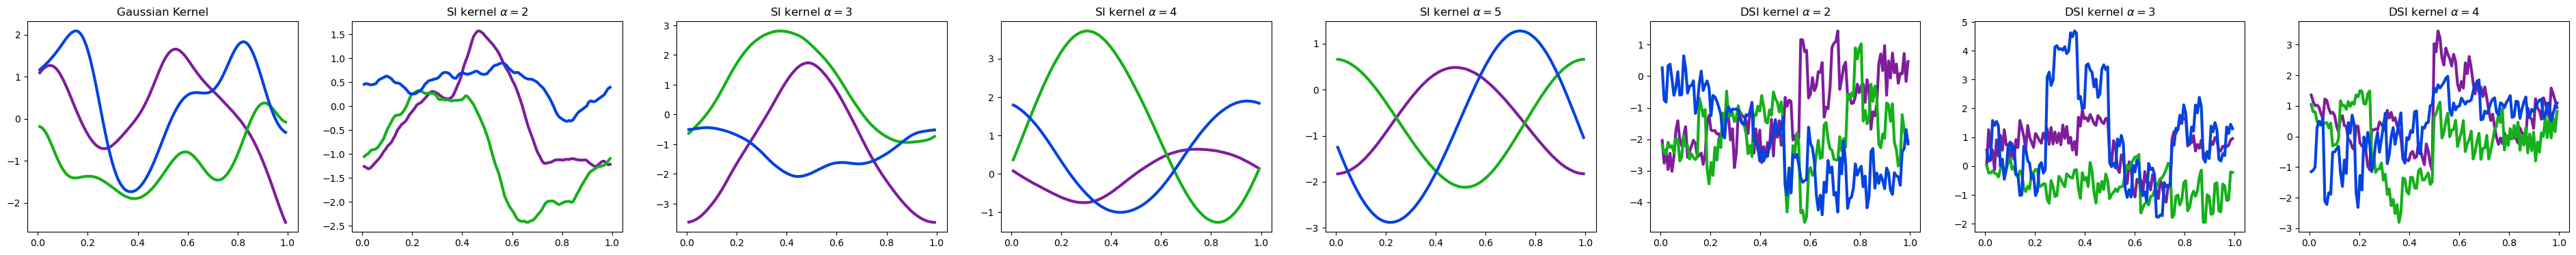

In [123]:
ndraws = 3
n = 127
t = 32
xticks = torch.linspace(0,1,n+2,device=DEVICE)[1:-1]
xbticks = torch.floor(xticks*2**t).to(torch.int64)
kmats = [
    ["Gaussian Kernel", qp.KernelGaussian(dimension=1,torchify=True,lengthscales=1e-2)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"SI kernel $\alpha=2$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=2)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"SI kernel $\alpha=3$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=3)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"SI kernel $\alpha=4$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=4)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"SI kernel $\alpha=5$", qp.KernelShiftInvar(dimension=1,torchify=True,lengthscales=1e0,alpha=5)(xticks[:,None],xticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"DSI kernel $\alpha = 2$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=2)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"DSI kernel $\alpha = 3$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=3)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
    [r"DSI kernel $\alpha = 4$", qp.KernelDigShiftInvar(dimension=1,torchify=True,lengthscales=1e0,t=t,alpha=4)(xbticks[:,None],xbticks[:,None])+1e-6*torch.eye(n,device=DEVICE)],
]
nrows = len(kmats)
#fig,ax = pyplot.subplots(nrows=nrows,ncols=1,figsize=(6,4*nrows))
fig,ax = pyplot.subplots(nrows=1,ncols=nrows,figsize=(6*nrows,4))
for i,(name,kmat) in enumerate(kmats):
    L = torch.linalg.cholesky(kmat)
    r = torch.randn(ndraws,n)
    draws = torch.einsum("ik,rk->ri",L,r)
    for j in range(ndraws):
        ax[i].plot(xticks,draws[j],color=COLORS[j],linewidth=LW)
        ax[i].set_title(name)

## 1d example

<function brownian_motion at 0x7fac4069dee0>
	GP, Gaussian kernel, grid
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 3.42e+06        1.52e-01        | 1.00e-01        | [1.00e+00]	[1.00e+00]	[1.00e-08]
                 25 | -1.42e+00       1.33e-01        | 1.00e-01        | [1.88e-02]	[3.50e+01]	[1.00e-08]
                 50 | -4.87e+01       1.25e-01        | 1.00e-01        | [9.39e-03]	[1.03e-01]	[1.00e-08]
                 75 | -4.88e+01       1.25e-01        | 1.00e-01        | [9.69e-03]	[1.19e-01]	[1.00e-08]
                100 | -4.88e+01       1.25e-01        | 1.00e-01        | [9.69e-03]	[1.19e-01]	[1.00e-08]
	Fast GPR, SI kernel, lattice $\alpha = 3$
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~

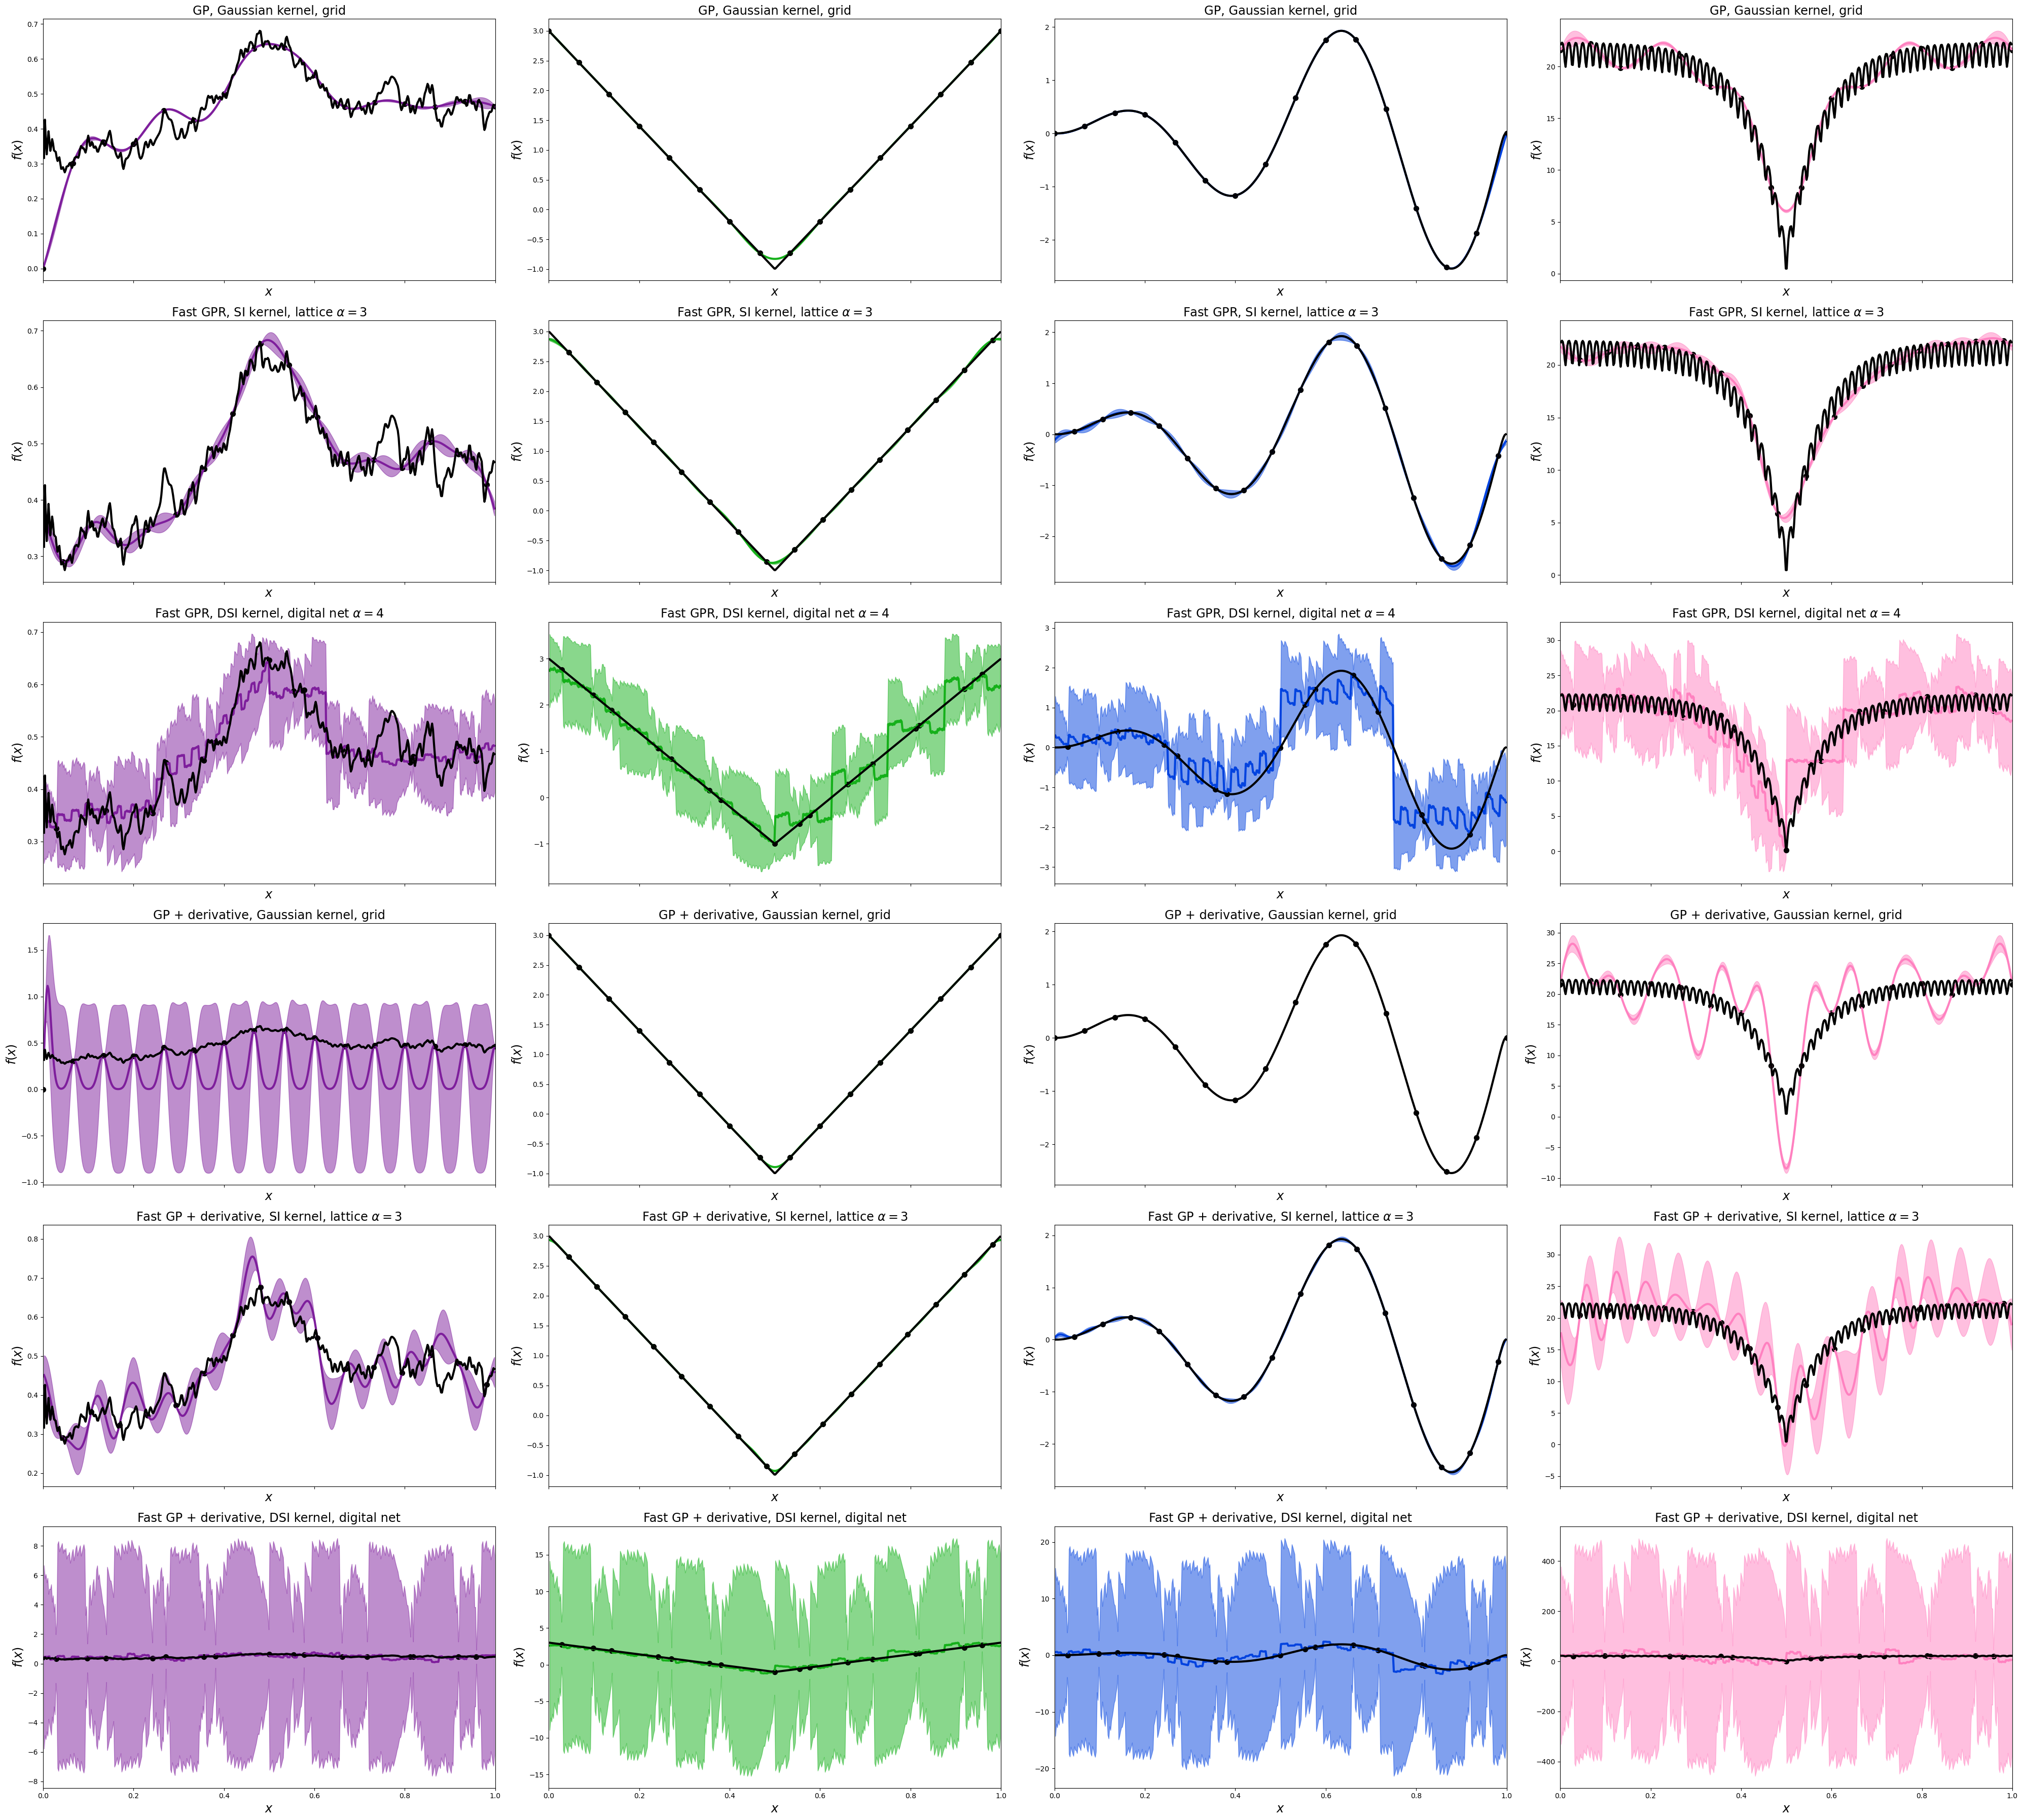

In [ ]:
d = 1
n = 2**4
nticks = 500
xticks = torch.linspace(0,1,nticks+2,device=DEVICE)[1:-1]
grid = torch.linspace(0,1,n,device=DEVICE)[:,None]
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)
lbetas_no_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]
lbetas_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]+[ej for ej in torch.eye(d,dtype=int,device=DEVICE)]
gps = [
    ["GP, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_no_grad,device=DEVICE),False],
    #[r"Fast GPR, SI kernel, lattice $\alpha = 2$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=2),False],
    [r"Fast GPR, SI kernel, lattice $\alpha = 3$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=3),False],
    #[r"Fast GPR, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=4),False],
    #[r"Fast GPR, DSI kernel, digital net $\alpha = 2$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=2),False],
    #[r"Fast GPR, DSI kernel, digital net $\alpha = 3$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=3),False],
    [r"Fast GPR, DSI kernel, digital net $\alpha = 4$", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_no_grad,device=DEVICE,alpha=4),False],
    ["GP + derivative, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_grad,device=DEVICE), True],
    [r"Fast GP + derivative, SI kernel, lattice $\alpha = 3$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=3), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 4$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=4), True],
    #[r"Fast GP + derivative, SI kernel, lattice $\alpha = 5$", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=5), True],
    ["Fast GP + derivative, DSI kernel, digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4), True],
]
funcs = [f_brownian_motion,f_G,f_curve_1d,f_ackley]
ncols = len(funcs)
nrows = len(gps)
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,6*nrows),sharex=True,sharey=False)
ax = np.atleast_1d(ax).reshape((nrows,ncols))
for j,f in enumerate(funcs):
    yticks = f(xticks[:,None])
    print(f)
    for i,(name,gp,grad) in enumerate(gps):
        print("\t"+name)
        if not grad:
            yf = f(gp.x)[:,None].to(DEVICE)
        else:
            yf = f_grad_f(f,gp.x).to(DEVICE)
        data = gp.fit(yf,xticks[:,None],yticks,opt_steps=100,verbose=25,opt_noises=False,lb_noises=1e-12,use_scheduler=False)#,optimizer_init = lambda params: torch.optim.Rprop(params,lr=1e-1))
        pmean = gp.post_mean(xticks[:,None])
        ax[i,j].plot(xticks.cpu(),pmean.cpu(),color=COLORS[j],linewidth=LW)
        pvar = gp.post_var(xticks[:,None])
        ci_low = pmean-ZSTAR*torch.sqrt(pvar)
        ci_high = pmean+ZSTAR*torch.sqrt(pvar)
        ax[i,j].fill_between(xticks.cpu(),ci_high.cpu(),ci_low.cpu(),color=COLORS[j],alpha=ALPHA)
        ax[i,j].scatter(gp.x[:,0].cpu(),yf[:,0].cpu(),color="k",s=MARKERSIZE)
        ax[i,j].plot(xticks.cpu(),yticks.cpu(),color="k",linewidth=LW)
        ax[i,j].set_title(name,fontsize="xx-large")
        ax[i,j].set_xlim([0,1])
        ax[i,j].set_xlabel(r"$x$",fontsize="xx-large")
        ax[i,j].set_ylabel(r"$f(x)$",fontsize="xx-large")
fig.tight_layout()
fig.savefig("./fgpr_figs/gp1d.%s.pdf"%name,dpi=256,bbox_inches="tight")

## 2d example

In [63]:
d = 2
n = 2**10
f = f_ackley
nticks = 129
x1ticks = x2ticks = torch.linspace(0,1,nticks+2,device=DEVICE)[1:-1]
x1mesh,x2mesh = torch.meshgrid(x1ticks,x2ticks,indexing="ij")
xticks = torch.vstack([x1mesh.flatten(),x2mesh.flatten()]).T 
yticks = f(xticks)
ymesh = yticks.reshape(x1mesh.shape)

In [64]:
grid1ticks = grid2ticks = torch.linspace(0,1,int(np.sqrt(n)),device=DEVICE)
grid1mesh,grid2mesh = torch.meshgrid(grid1ticks,grid2ticks,indexing="ij")
grid = torch.vstack([grid1mesh.flatten(),grid2mesh.flatten()]).T
assert len(grid)==n
lattice = qp.Lattice(d,seed=7) 
dnb2 = qp.DigitalNetB2(d,seed=7)
dnb2_alpha2 = qp.DigitalNetB2(d,seed=7,alpha=2)
dnb2_alpha3 = qp.DigitalNetB2(d,seed=7,alpha=3)
dnb2_alpha4 = qp.DigitalNetB2(d,seed=7,alpha=4)

In [65]:
lbetas_grad = [torch.zeros((1,d),dtype=int,device=DEVICE)]+[ej for ej in torch.eye(d,dtype=int,device=DEVICE)]
gps_grad = [
    ["GP, Gaussian kernel, grid", qp.GPR(grid,lbetas=lbetas_grad,device=DEVICE)],
    ["Fast GP, SI kernel, lattice", qp.FGPRLattice(lattice,n,lbetas=lbetas_grad,device=DEVICE,alpha=3)],
    ["Fast GP, DSI kernel, digital net", qp.FGPRDigitalNetB2(dnb2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=2", qp.FGPRDigitalNetB2(dnb2_alpha2,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=3", qp.FGPRDigitalNetB2(dnb2_alpha3,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
    #["Fast GP, DSI kernel, digital net alpha=4", qp.FGPRDigitalNetB2(dnb2_alpha4,n,lbetas=lbetas_grad,device=DEVICE,alpha=4)],
]
for name,gp in gps_grad:
    print(name) 
    yf = f_grad_f(f,gp.x)
    data = gp.fit(yf,
        opt_steps=100,verbose=10,opt_noises=True,lb_noises=1e-12)
    yhat = gp.post_mean(xticks)
    l2rerror = torch.linalg.norm(yhat-yticks)/torch.linalg.norm(yticks)
    print("    L2RError: %.2e"%l2rerror)
    gp.y = yf

GP, Gaussian kernel, grid
        iter of 100 | MLL             L2RError        | lr              | lengthscales, global_scale, noises
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  0 | 4.63e+15        nan             | 1.00e-01        | [1.00e+00 1.00e+00]	[1.00e+00]	[1.00e-08 1.00e-08 1.00e-08]
                 10 | 2.16e+10        nan             | 1.00e-01        | [2.54e-03 2.54e-03]	[3.94e+02]	[3.94e-06 3.94e-06 3.94e-06]
                 20 | 3.30e+04        nan             | 1.00e-01        | [6.32e-04 6.32e-04]	[1.58e+03]	[1.58e-05 1.58e-05 1.58e-05]
                 30 | 3.26e+04        nan             | 1.00e-01        | [6.02e-04 6.02e-04]	[1.26e+03]	[1.62e-05 5.21e-06 5.21e-06]
                 40 | 3.19e+04        nan             | 1.00e-01        | [5.69e-04 5.69e-04]	[5.33e+02]	[1.35e-05 4.04e-09 4.04e-09]
                 50 | 3.10e+04        nan             | 1.00e-01        | [4.86e-04 4.

/tmp/ipykernel_2333262/3096979913.py:7
/tmp/ipykernel_2333262/3096979913.py:52
/tmp/ipykernel_2333262/3096979913.py:53
/tmp/ipykernel_2333262/3096979913.py:52
/tmp/ipykernel_2333262/3096979913.py:53
/tmp/ipykernel_2333262/3096979913.py:52
/tmp/ipykernel_2333262/3096979913.py:53


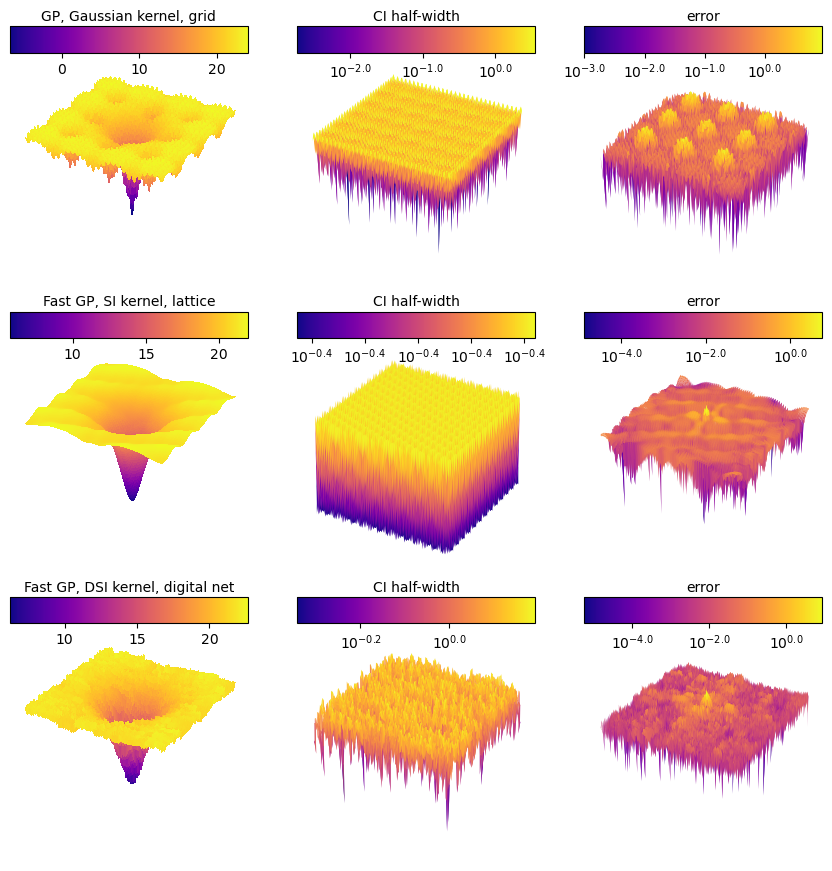

In [66]:
CMAP = cm.plasma
nrows = len(gps_grad)
ncols = 3
fig = pyplot.figure(figsize=(3.5*ncols,3.5*nrows))
ax = np.array([[fig.add_subplot(nrows,ncols,ncols*i+j+1,projection="3d") for j in range(ncols)] for i in range(nrows)],dtype=object)
pmeanmeshes = torch.vstack([gp.post_mean(xticks).reshape(x1mesh.shape)[None,:,:].cpu() for _,gp in gps_grad])
cihwmeshes = np.log10(ZSTAR*torch.sqrt(torch.vstack([gp.post_var(xticks).reshape(x1mesh.shape)[None,:,:].cpu() for _,gp in gps_grad])))
errormeshes = torch.log10(torch.abs(pmeanmeshes-ymesh.cpu()))
for i,(name,gp) in enumerate(gps_grad):
    pmean_max,pmean_min = pmeanmeshes[i].max(),pmeanmeshes[i].min()
    error_max,error_min = errormeshes[i].max(),errormeshes[i].min()
    cihw_max,cihw_min = cihwmeshes[i].max(),cihwmeshes[i].min()
    norm_pmean = colors.Normalize(vmin=pmean_min,vmax=pmean_max)
    norm_err = colors.Normalize(vmin=error_min,vmax=error_max)
    norm_cihw = colors.Normalize(vmin=cihw_min,vmax=cihw_max)
    surf_func = ax[i,0].plot_surface(x1mesh.cpu(),x2mesh.cpu(),pmeanmeshes[i],
        cmap=CMAP,
        #vmin=pmean_min,vmax=pmean_max,
        #facecolors=CMAP(norm_pmean(pmeanmeshes[i])),
        antialiased=False,rstride=1,cstride=1,edgecolor='none')
    surf_cihw = ax[i,1].plot_surface(x1mesh.cpu(),x2mesh.cpu(),cihwmeshes[i],
        cmap=CMAP,
        #vmin=cihw_min,vmax=cihw_max,
        #facecolors=CMAP(norm_cihw(cihwmeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    surf_err = ax[i,2].plot_surface(x1mesh.cpu(),x2mesh.cpu(),errormeshes[i],
        cmap=CMAP,
        #vmin=error_min,vmax=error_max,
        #facecolors=CMAP(norm_err(errormeshes[i])),
        antialiased=True,rstride=1,cstride=1,edgecolor='none')
    cax_pmean = fig.add_axes([
        ax[i,0].get_position().x0,
        ax[i,0].get_position().y1,
        ax[i,0].get_position().x1-ax[i,0].get_position().x0,
        0.025,
    ])
    cax_cihw = fig.add_axes([
        ax[i,1].get_position().x0,
        ax[i,1].get_position().y1,
        ax[i,1].get_position().x1-ax[i,1].get_position().x0,
        0.025,
    ])
    cax_err = fig.add_axes([
        ax[i,2].get_position().x0,
        ax[i,2].get_position().y1,
        ax[i,2].get_position().x1-ax[i,2].get_position().x0,
        0.025,
    ])
    cbar_pmean = fig.colorbar(cm.ScalarMappable(norm=norm_pmean,cmap=CMAP),cax_pmean,orientation="horizontal",label=name)
    cbar_cihw = fig.colorbar(cm.ScalarMappable(norm=norm_cihw,cmap=CMAP),cax_cihw,orientation="horizontal",label="CI half-width")
    cbar_err = fig.colorbar(cm.ScalarMappable(norm=norm_err,cmap=CMAP),cax_err,orientation="horizontal",label="error")
    cbar_err.ax.set_xticklabels([r"$10^{%.1f}$"%tick for tick in cbar_err.ax.get_xticks()])
    cbar_cihw.ax.set_xticklabels([r"$10^{%.1f}$"%tick for tick in cbar_cihw.ax.get_xticks()])
    cbar_err.ax.xaxis.set_label_position('top')
    cbar_cihw.ax.xaxis.set_label_position('top')
    cbar_pmean.ax.xaxis.set_label_position('top')
    #ax[i,0].set_title(name)
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis("off")
        ax[i,j].set_xlim([0,1]); ax[i,j].set_xticks([0,1])
        ax[i,j].set_ylim([0,1]); ax[i,j].set_yticks([0,1])
        ax[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax[i,j].xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax[i,j].yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax[i,j].zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
         #ax[i,j].set_xlabel(r"$x_1$",fontsize="xx-large")
        #ax[i,j].set_ylabel(r"$x_2$",fontsize="xx-large")
    ax[i,0].set_zlabel(r"$f(\mathbf{x})$",fontsize="xx-large")
    ax[i,1].set_zlabel(r"$|f(\mathbf{x})-f_{\mathrm{true}}(\mathbf{x})|$",fontsize="xx-large")
    #ax[i,0].set_zlim([pmeanmeshes.min(),pmeanmeshes.max()]); ax[i,j].set_yticks([0,1])
    #ax[i,1].zaxis._set_scale('log')
    #ax[i,1].set_zscale("log",base=10)
#fig.tight_layout()
fig.savefig("./fgpr_figs/fgp_2d.pdf",bbox_inches="tight",dpi=256)

## Speed Comparison

In [67]:
dvec = torch.tensor([1,2,4,8,16],dtype=int)
nvec = 2**torch.arange(0,10,dtype=int)
gps = [
    ["GP Gauss lattice", lambda d,n: qp.GPR(qp.Lattice(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    ["GP Gauss digital net", lambda d,n: qp.GPR(qp.DigitalNetB2(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    ["GP SI lattice", lambda d,n: qp.FGPRLattice(qp.Lattice(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    ["GP DSI digital net", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    #[r"GP DSI digital net $\alpha = 2$", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,alpha=2),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    #[r"GP DSI digital net $\alpha = 3$", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,alpha=3),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
    #[r"GP DSI digital net $\alpha = 4$", lambda d,n: qp.FGPRDigitalNetB2(qp.DigitalNetB2(d,alpha=4),n,lbetas=[torch.zeros(d,dtype=int,device=DEVICE)],device=DEVICE,alpha=2)],
]
print("dvec = %s"%str(dvec.numpy()))
print("nvec = %s"%str(nvec.numpy()))
print()
times = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
l2rerrors = torch.nan*torch.zeros((len(gps),len(dvec),len(nvec)))
for j,d in enumerate(dvec):
    x_test = torch.from_numpy(qp.Halton(d,seed=7)(2**10)).to(DEVICE)
    print("d = %d"%d)
    for i,n in enumerate(nvec):
        print("    n = %d"%n)
        for k,(name,gp_constructor) in enumerate(gps):
            gp = gp_constructor(d,int(n))
            y = f_ackley(gp.x)[:,None]
            y_test = f_ackley(x_test)
            data = gp.fit(y,opt_steps=250,verbose=0,opt_noises=True,lb_noises=1e-12,verbose_indent=8)
            yhat = gp.post_mean(x_test)
            l2rerrors[k,j,i] = torch.linalg.norm(y_test-yhat)/torch.linalg.norm(y_test)
            times[k,j,i] = torch.mean(data["times"][10:-10]-data["times"][9:-11])
            print("        %35s: \tl2 relative error = %-15.2e time = %-15.2e"%(name,l2rerrors[k,j,i],times[k,j,i]))

dvec = [ 1  2  4  8 16]
nvec = [  1   2   4   8  16  32  64 128 256 512]

d = 1
    n = 1
                           GP Gauss lattice: 	l2 relative error = 2.90e-01        time = 2.37e-03       
                       GP Gauss digital net: 	l2 relative error = 3.00e-01        time = 2.45e-03       
                              GP SI lattice: 	l2 relative error = 1.11e+00        time = 3.27e-03       
                         GP DSI digital net: 	l2 relative error = 1.04e+00        time = 3.96e-03       
    n = 2
                           GP Gauss lattice: 	l2 relative error = 3.37e-01        time = 6.13e-03       
                       GP Gauss digital net: 	l2 relative error = 6.13e-01        time = 3.00e-03       
                              GP SI lattice: 	l2 relative error = 3.52e-01        time = 2.93e-03       
                         GP DSI digital net: 	l2 relative error = 2.49e-01        time = 3.18e-03       
    n = 4
                           GP Gauss lattice: 	l2 r

KeyboardInterrupt: 

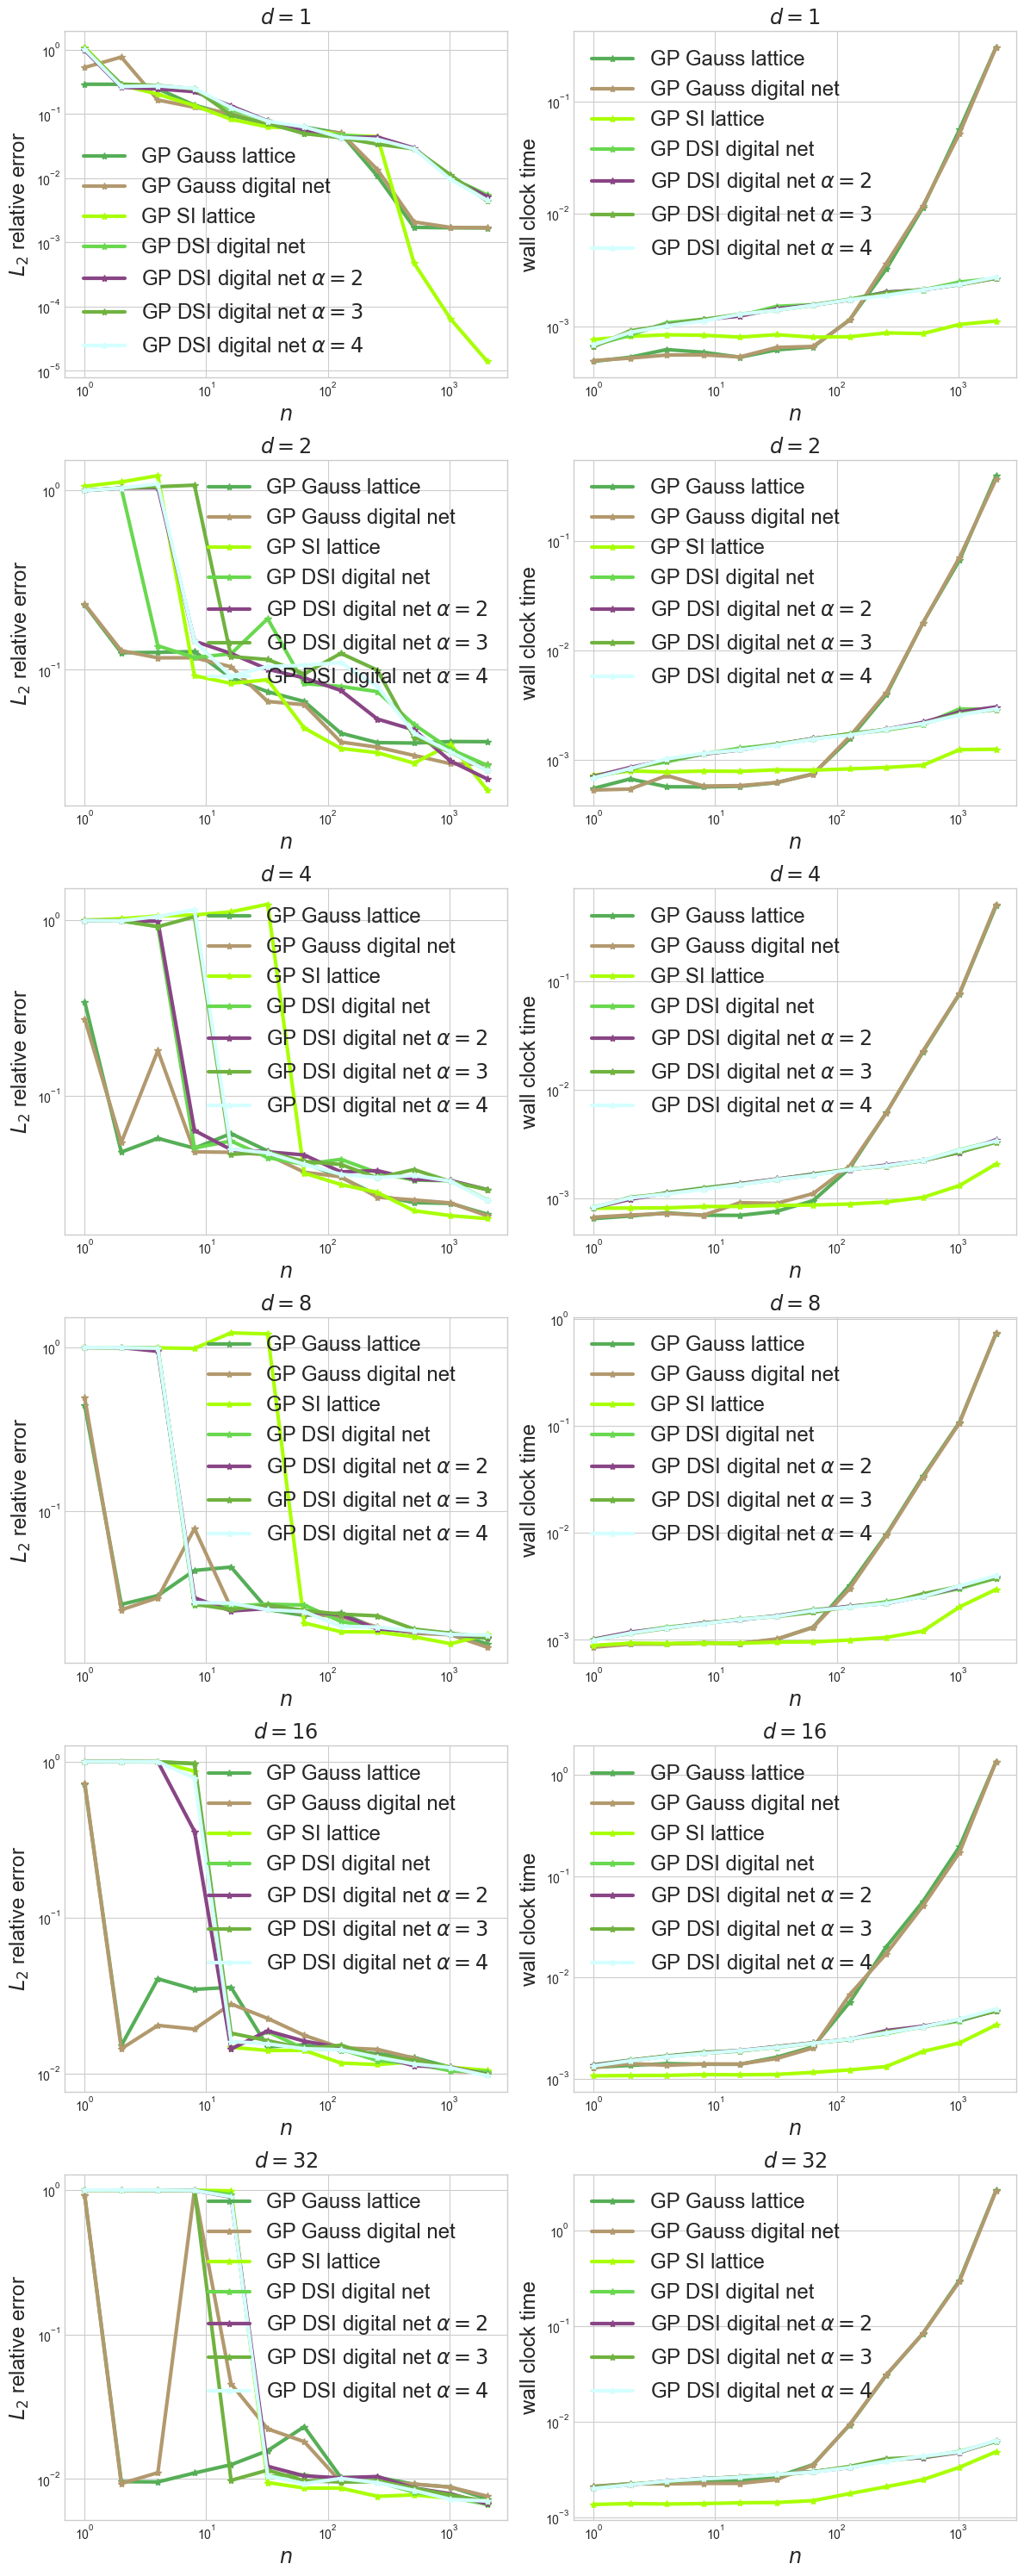

In [33]:
nrows = len(dvec)
ncols = 2
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(6*ncols,5*nrows))
for j in range(times.size(1)):
    for k in range(times.size(0)):
        ax[j,0].plot(nvec,l2rerrors[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW)
        ax[j,1].plot(nvec,times[k,j],marker="*",color=COLORS[k],label=gps[k][0],linewidth=LW)
for j in range(nrows):
    for i in range(ncols):
        ax[j,i].set_xscale("log",base=10)
        ax[j,i].set_yscale("log",base=10)
        ax[j,i].legend(frameon=False,fontsize="xx-large")
        ax[j,i].set_title(r"$d=%d$"%dvec[j],fontsize="xx-large")
    ax[j,0].set_xlabel(r"$n$",fontsize="xx-large")
    ax[j,0].set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
    ax[j,1].set_xlabel(r"$n$",fontsize="xx-large")
    ax[j,1].set_ylabel("wall clock time",fontsize="xx-large")
fig.tight_layout()
